## Israel Elections Data Analysis final report

## Gil Shiloh, Elky Shandor and Dean Tesler



In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw
code."></form>''')

In [ ]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

Running on CoLab


In [ ]:
# Mount drive in google colab
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
else:  # Set local path 
    data_path = "/Users/elkysandor/Desktop/huji yr3/static lab/"

Mounted at /content/drive


First, we need to mount our local drive to the colab network

In [ ]:
# Loading elections 2021 elections data:
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Saving votes per city 2021.csv to votes per city 2021.csv
Saving votes per city 2020.csv to votes per city 2020.csv
Saving votes per ballot 2021.csv to votes per ballot 2021.csv
Saving votes per ballot 2020.csv to votes per ballot 2020.csv
Saving HevratiCalcaliYeshuvim.csv to HevratiCalcaliYeshuvim.csv
Saving eshkol_hevrati_calcali.csv to eshkol_hevrati_calcali.csv


In [ ]:
#pip install -U matplotlib


In [ ]:
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
import statsmodels.api as sm  # a module for statistical modelling (e.g. regression analysis)
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from scipy.optimize import nnls
import io
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
parties_dict_2021 ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}
big_nine = ['אמת','ג','ודעם','טב','ל','מחל','נץ','פה','שס']
parties_dict_2020 = {"אמת":"עבודה", "ג":"יהדות התורה", "ודעם": "הרשימה המשותפת", "ל":"ישראל ביתנו", "מחל":"הליכוד", "פה":"יש עתיד", "שס":"שס","נץ":"עוצמה יהודית", "טב":"ימינה"}
gush_right = {"ט":"הציונות הדתית", "ב":"ימינה","ג":"יהדות התורה","שס":"שס","מחל":"הליכוד","ל":"ישראל ביתנו","ת":"תקוה חדשה"}
gush_left = {"אמת":"העבודה","פה":"יש עתיד","פה":"כחול לבן","מרצ":"מרצ","ודעם":"הרשימה המשותפת","עם":"רעם"}

In [ ]:
# Compute votes share only for parties above a certain threshold 
def parties_votes_percents(df, thresh):
    par = df.div(df.sum(axis = 1), axis = 0)
    return par[par > thresh]

In [ ]:
if   run_in_colab:
    df_2021_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_2020_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_2020_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_2021_eshkol = pd.read_csv(io.BytesIO(uploaded['eshkol_hevrati_calcali.csv']),  encoding = 'iso-8859-8')
    df_2021_eshkol_yeshuvim = pd.read_csv(io.BytesIO(uploaded['HevratiCalcaliYeshuvim.csv']),  encoding = 'iso-8859-8')
else:
    df_2021_eshkol_yeshuvim = pd.read_csv(data_path + 'HevratiCalcaliYeshuvim.csv',  encoding = 'iso-8859-8')  # need to read locally
    df_2021_eshkol = pd.read_csv(data_path + 'eshkol_hevrati_calcali.csv',  encoding = 'iso-8859-8')  # need to read locally
    df_2020_ballots_raw = pd.read_csv(data_path + 'votes per ballot 2020.csv',  encoding = 'iso-8859-8', index_col='שם ישוב').sort_index()  # need to read locally
    df_2021_ballots_raw = pd.read_csv(data_path + 'votes per ballot 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב').sort_index()  # need to read locally
    df_2021_raw = pd.read_csv(data_path + 'votes per city 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב').sort_index()  # need to read locally  
    df_2020_raw = pd.read_csv(data_path + 'votes per city 2020.csv',  encoding = 'iso-8859-8', index_col='שם ישוב').sort_index()  # need to read locally
  

# א

לאורך הקורס השתמשנו בקבצי נתונים רשמיים של הבחירות לכנסת ה23 בשנת 2020 ושל הבחירות לכנסת ה24 בשנת 2021. 
השתמשנו בקובץ נתונים אחד אשר התייחס לתוצאות הבחירות על פי הקלפיות לכל שנה בנפרד והשתמשנו בקובץ אשר התייחס לתוצאות הבחירות על פי ישובים לכל שנה בנפרד. בנוסף לקבצים הללו השתמשנו בקובץ המתייחס לאשכול החברתי-כלכלי.
האינפורמציה שהשתמשנו בבחירות על פני הקלפיות/יישובים בשנים 2020/1 – שם הישוב, מספר הקולות הכשרים, מספר הקולות הפסולים, מספר המצביעים הכללי בקלפי, מספר בעלי זכות הבחירה, מספר הקלפי, מספר הישוב וכמובן מספר המצביעים לכל מפלגה בקלפי. בנוסף עיבדנו את אינפורמציה זו לשכיחויות.
האינפורמציה שהשתמשנו בבחירות בשנת 2021 בנוגע לאשכול חברתי כלכלי – שם הישוב, סמל הישוב, ודירוג האשכול החברתי-כלכלי אשר נע מ1 עד 10, איחדנו את מידע זה עם הישובים בשנת 2021.
העיבוד המוקדם השתנה לפי הצורך במעבדה/שאלה. העיבוד המוקדם שעשינו לנתונים הוא שסיננו את המידע רק לכמות המצביעים לכל מפלגה בכל קלפי/ישוב. בנוסף יצרנו דאטה שמכיל את קלפיות/ישובים שקיימות בשתי מערכות הבחירות. בשאלות שרצינו לחשב רק על פני 13 המלפגות הגדולות בשנת 2021 השתמשנו רק ב13 המפלגות הגדולות, בשנת 2020 היה הרכב שונה של מפלגות, חלק מהמפלגות היו מאוחדות והתפצלו בשנת 2021 וחלק לא היו קיימות בשנת 2020. כדי להתגבר על כך ולהשוות בין שני מערכות הבחירות ביצענו את הפיצולים הבאים:
פיצול קולות העבודה-גשר מרצ ב2020 למרצ ועבודה ב2021 במשקל שווה.
פיצול קולות הרשימה המשותפת ב2020 לרע"ם (40%) והרשימה המשותפת (60%) ב2021
פיצול קולות הליכוד ב2020 לליכוד (83.3%) ולתקוה חדשה (16.7%) ב2021
פיצול קולות כחול לבן ב2020 לכחול לבן (33.3%) ויש עתיד (66.7%) ב2021
פיצול קולות ימינה-הבית היהודי-האיחוד הלאומי ב2020 לימינה (60%) ולציונות הדתית (40%) ב2021
העברת קולות עוצמה יהודית ב2020 לציונות הדתית ב2021


In [ ]:
df_2020_ballots_raw = df_2020_ballots_raw.drop(index = "מעטפות חיצוניות").dropna(axis=1,how="all").set_index("קלפי",append=True).sort_index()
df_2020_ballots = df_2020_ballots_raw.iloc[:,8:].sort_index(axis=1)
df_2020_ballots = df_2020_ballots.drop("כשרים", axis=1)

In [ ]:
df_2020_split_ballots = df_2020_ballots_raw.copy(deep=True)
df_2020_split_ballots["מרצ"] = df_2020_split_ballots["אמת"]*0.5
df_2020_split_ballots["אמת"] = df_2020_split_ballots["אמת"]*0.5
df_2020_split_ballots["עם"] = df_2020_split_ballots["ודעם"]*0.4
df_2020_split_ballots["ודעם"] = df_2020_split_ballots["ודעם"]*0.6
df_2020_split_ballots["ת"] = df_2020_split_ballots["מחל"]*0.167
df_2020_split_ballots["מחל"] = df_2020_split_ballots["מחל"]*0.833
df_2020_split_ballots["כן"] = df_2020_split_ballots["פה"]*0.333
df_2020_split_ballots["פה"] = df_2020_split_ballots["פה"]*0.667
df_2020_split_ballots["ב"] = df_2020_split_ballots["טב"]*0.6
df_2020_split_ballots["ט"] = df_2020_split_ballots["טב"]*0.4
df_2020_split_ballots["ט"] = df_2020_split_ballots["ט"]+df_2020_split_ballots["נץ"]
df_2020_split_ballots = df_2020_split_ballots.drop(columns = "נץ")
df_2020_split_ballots = df_2020_split_ballots.drop(columns = "טב")
df_2020_split_ballots = df_2020_split_ballots.sort_index(axis=1)
df_2020_split_ballots_big_par = df_2020_split_ballots[parties_dict_2021.keys()]

In [ ]:
df_2021_ballots_raw = df_2021_ballots_raw.drop(index = "מעטפות חיצוניות").dropna(axis=1,how="all").set_index("קלפי",append=True).sort_index()
df_2021_ballots = df_2021_ballots_raw.iloc[:,8:].sort_index(axis=1)
df_2021_ballots = df_2021_ballots.drop("כשרים", axis=1)

In [ ]:
df_2021_raw = df_2021_raw.drop(index = "מעטפות חיצוניות").dropna(axis=1,how="all").sort_index()
df_city_2021 = df_2021_raw.iloc[:,6:]
df_2020_raw = df_2020_raw.drop(index = "מעטפות חיצוניות").dropna(axis=1,how="all").sort_index()
df_city_2020 = df_2020_raw.iloc[:,6:]

In [ ]:
perc_ball_2021 = parties_votes_percents(df_2021_ballots, -1)
perc_ball_2020 = parties_votes_percents(df_2020_ballots, -1)
perc_city_2021 = parties_votes_percents(df_city_2021, -1)
perc_city_2020 = parties_votes_percents(df_city_2020, -1)

In [ ]:
#הנתונים של הקלפיות המשותפות
before_merge = pd.concat([df_2021_ballots_raw,df_2020_split_ballots])
needed_idx = before_merge.index.value_counts()[before_merge.index.value_counts()==2].index
final_merge = before_merge.loc[needed_idx].sort_index(level=0).fillna(0)
final_merge # מכיל את כל הדאטה של 2020 ו2021
merge_parties_perc = final_merge.iloc[:,9:]
merge_parties_perc = merge_parties_perc.div(merge_parties_perc.sum(axis = 1),axis=0)

In [ ]:
#כל הדאטה של כלכלי חברתי
merge_calcali = df_2021_raw.merge(df_2021_eshkol, how = 'inner',right_on = "set_code", left_on = "סמל ישוב").dropna(axis=1,how="all")
names_idx = df_2021_raw.index[df_2021_raw["סמל ישוב"].isin(df_2021_eshkol["set_code"])]
merge_calcali = merge_calcali.set_axis(names_idx)
df_2021_ballots_with_calacali = df_2021_ballots.join(merge_calcali["eco_level"])
random_fill = np.random.randint(2,4,93) # מילאנו את החסר על פי ידע מקדים על הישובים הספציפיים
df_2021_ballots_with_calacali["eco_level"].fillna(2,inplace=True)

# ב

מפלגת מרץ בשנת 2020 הייתה חלק ממפלגה מאוחדת – העבודה גשר מרץ לעומת בחירות 2021 שבה רצה לבד. הקולות התפצלו באופן הבא : פיצול קולות העבודה-גשר מרצ ב2020 למרצ  ועבודה ב2021 במשקל שווה כאשר על מנת לבצע את הפיצולים היה נדרש ידע מקדים שבדיעבד התלכד עם החישוב הסטטיסטי.
ניקח זאת בחשבון בחישובינו בכך שעל מנת להשוות בין הקולות של מרץ בבחירות 2020 אנו נתייחס אליהם כחצי מהקולות של העבודה גשר מרץ וכך נקבל את המשקל היחסי של הקולות שהצביעו למפלגת מרץ לכל ישוב/קלפי.


# ג

In [ ]:
bazab = df_2021_ballots_raw["בזב"]
model = sm.OLS(bazab,df_2021_ballots[parties_dict_2021.keys()]).fit()
beta = model.params
df = pd.DataFrame({"אחוז ההצבעה המשוער בקרב הבוחרים הפוטנציאלים של המפלגה": [beta["מרצ"]**-1]}, index=['בחירות 2021'])
round(df*100,3)

,אחוז ההצבעה המשוער בקרב הבוחרים הפוטנציאלים של המפלגה
בחירות 2021,43.741


על מנת למצוא את אחוז ההצבעה המשוער בקרב הבוחרים הפוטנציאלים של המפלגה נעשה רגרסיית "הריבועים הפחותים". אחוז זה נראה נמוך ביחס למפלגה שקיבלה 4 מנדטים, אך זה לגיטימי בשל כך שישנן מפלגות שתומכיהן הוא אותו קהל ( לדוגמה עבודה ואמת), אז ייתכן כי התומכים יבחרו באחת מהמפלגות הללו.

In [ ]:
def comparing(df1, df2, thresh):
  width = 0.2
  votes = parties_votes(df1, thresh) 
  real_votes = votes["מרצ"]
  n = 1  
  fixed_votes = parties_votes(df2, thresh)
  fixed_meretz = fixed_votes["מרצ"]
  fig, ax = plt.subplots()  
  all_bar = ax.bar(np.arange(n), real_votes, width, color='g',alpha=0.9)
  fix_bar = ax.bar(np.arange(n)+width*1.2, fixed_meretz, width, color='purple',alpha=0.9)
  ax.set_ylabel('Votes percent')
  plt.ylim(0,0.09)
  ax.set_title('Resoults for "MERETZ"')
  ax.set_xticks(np.arange(n))
  ax.legend((all_bar[0], fix_bar[0]), ('Real election', 'After correcting'))
  ax.text(-0.03,0.059,str(round(real_votes*100,3))+"%",size=14)
  ax.text(0.2,0.055,str(round(fixed_meretz*100,3))+"%",size=14)
  plt.tick_params(
    axis='x',      
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)  
  plt.show()

  return fig, ax

In [ ]:
 def parties_votes(df, thresh):
    par = df.sum().div(df.sum().sum())
    return par[par > thresh]

 bazab = df_2021_raw.loc[:,'בזב']
 kosher = df_2021_raw.loc[:,"כשרים"]
 normalized_Unacceptable = bazab/kosher
 estimated_df = df_city_2021.mul(normalized_Unacceptable,axis = 0)
 votes1 = parties_votes(df_city_2021, 0.035)["מרצ"]*100
 votes2 = parties_votes(estimated_df, 0.035)["מרצ"]*100

כאן נרצה להציג מה היה אחוז ההצבעה למפלגת מרצ אם כל בעלי זכות הבחירה היו מצביעים.
נעשה זאת באמצעות נירמול התוצאות לפי הכפלה בבזב חלקי הכשרים.

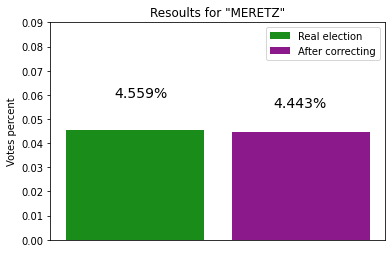

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Resoults for "MERETZ"'}, ylabel='Votes percent'>)

In [ ]:
comparing(df_city_2021,estimated_df,0.035)

מהמידע מעלה ניתן לראות שאחוז ההצבעה בקרב מצביעי מרצ הוא גבוה מהממוצע, ואם כל בעלי זכות הבחירה היו מצביעים אז אחוז ההצבעה למרצ היה נמוך יותר.

# ד

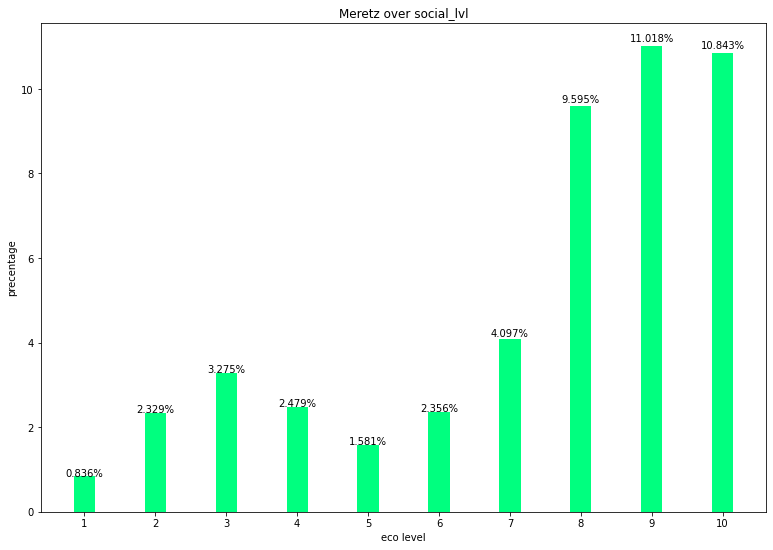

In [ ]:
def plot_derugs():
    plt.figure(figsize = (13, 9))
    names = parties_dict_2021.keys()
    names = [parties_dict_2021[name] for name in list(names)]
    rev_names = [party[::-1] for party in names]
    meretz_over_social = np.zeros(10)
    social_lvl =1
    for n in range(10):
          data_to_plot = merge_calcali.loc[merge_calcali.eco_level.eq(social_lvl)]
          rdy_to_plot = data_to_plot[parties_dict_2021.keys()]
          p = rdy_to_plot.sum().div(rdy_to_plot.sum().sum())
          meretz_over_social[n] = p.loc["מרצ"]*100
          social_lvl += 1
    graph = plt.bar(np.arange(10), list(meretz_over_social),0.3,color = "springgreen")
    plt.xticks(range(0,10),np.arange(1,11))
    plt.title('Meretz over ' + "social_lvl") 
    plt.xlabel("eco level")
    plt.ylabel("precentage")
    for i,bar in enumerate(graph):
      width = bar.get_width()
      height = bar.get_height()
      x, y = bar.get_xy()
      plt.text(x+width/2,
              y+height*1.01,
              str(meretz_over_social[i].round(3))+'%',
              ha='center')      
    plt.show
plot_derugs()

בגרף זה הצגנו את אחוזי ההצבעה למרץ בכל אשכול, ניתן לראות שהאחוזים קטנים מ11% כיאה למפלגה קטנה. מהגרף ניתן להבחין שהאשכולות שבהם מרץ מקבלים הרבה אחוזי תמיכה נמצאים באשכולות 8-10, ובאשכולות אלו אחוז ההצבעה למרץ הוא בערך כפי 2 מאחוז ההצבעה הכללי שראינו בסעיף הקודם.

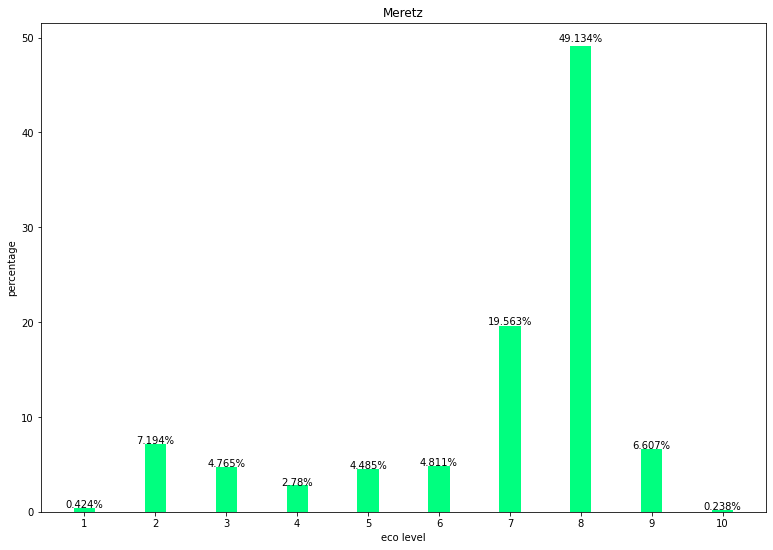

In [ ]:
def plot_eshkolot():
    for_agg = merge_calcali.loc[:,list(parties_dict_2021.keys())+['eco_level']]
    nice_data = for_agg.groupby('eco_level').agg("sum")
    p_mat = nice_data.div(nice_data.sum())
    plt.figure(figsize=(13, 9))
    p_mat = p_mat*100
    graph = plt.bar(np.arange(10),p_mat["מרצ"],0.3,color="springgreen")
    plt.xticks(range(0,10),np.arange(1,11))
    plt.xlabel("eco level")
    plt.ylabel("percentage")
    plt.title("Meretz")
    for i,bar in enumerate(graph):
      width = bar.get_width()
      height = bar.get_height()
      x, y = bar.get_xy()
      plt.text(x+width/2,
              y+height*1.01,
              str(p_mat["מרצ"].iloc[i].round(3))+'%',
              ha='center')
    plt.show()
plot_eshkolot()

מגרף זה ניתן לראות בבירור שרוב המצביעים למרץ נמצאים באשכולות 7-8 שמאשש את הטענות שמוקדי הכוח של המפלגה הם האשכולות חברתי-כלכלי הגבוהים בחברה הישראלית. נציין כי גרף זה אינו סותר את הגרף הקודם מפני שהוא לוקח בחשבון את מספר המצביעים באשכול.

In [ ]:
top_meretz = perc_city_2021["מרצ"].quantile(0.91)
# print(f" הסתכלנו על הישובים בהם אחוז ההצבעה למרץ היה גדול מן האחוזון {top_meretz.round(3)} (עיגלנו אותו כלפי מעלה), זהו האחוזון ה91") 
meretz = perc_city_2021.loc[perc_city_2021["מרצ"]>0.20]

In [ ]:
strong_meretz = meretz.index
filter_strong_meretz = strong_meretz.drop(['כישור', 'פלך', 'צבעון']) # ישובים אלה אינם נמצאים בדאטה הכלכלי וחברתי ולכן הורדנו אותם

בחרנו את האחוזון ה91 שבו מרץ מקבלים את אחוזי הצבעה הגבוהים ביותר על מנת לבחון את מוקד הכוח העיקרי של מרץ.

In [ ]:
# טבלה שמציגה את המחוזות שמרץ חזקים בהם
merge_calcali.loc[filter_strong_meretz]
populaion_strong_meretz = merge_calcali.loc[filter_strong_meretz].loc[:,["population","eco_level"]]
populaion_strong_meretz.describe()

,population,eco_level
count,95.000000,95.000000
mean,689.394752,6.515789
std,405.320138,1.616821
min,125.000000,2.000000
25%,441.500000,6.000000
50%,640.000000,7.000000
75%,848.500000,8.000000
max,3025.501398,9.000000


בחרנו לנתח את מוקדי הכוח של המפלגה ועל כן הסתכלנו באחוזונים העליונים של תומכי המפלגה. תחילה בחרנו להתמקד בגודל האוכלוסייה ובמצב הכלכלי בישובים אלו.

ניתן לראות שממוצע האשכול חברתי-כלכלי בישובים אלו הוא 6.5 עם סטיית תקן קטנה יחסית כ - 1.6 ועם חציון ששוה ל-7, ממצאים אשר מחזקים את הטענה שהאשכולות הגבוהים תומכים במרץ.

לגבי גודל האוכלוסיה ניתן לראות שמרץ חזקה בישובים קטנים, שממוצע האוכלוסיה בישובים החזקים הוא 689 והיישוב המקסימלי מכיל 3025 איש.

In [ ]:
relig_compare_to_meretz = perc_city_2021.loc[filter_strong_meretz].loc[:,["שס", "ג", "ט", "מרצ"]]#.sum(axis = 1)
relig_compare_to_meretz.describe()

,שס,ג,ט,מרצ
count,95.000000,95.000000,95.000000,95.000000
mean,0.001454,0.000754,0.005033,0.298128
std,0.002252,0.001680,0.006056,0.071720
min,0.000000,0.000000,0.000000,0.200893
25%,0.000000,0.000000,0.000000,0.234038
50%,0.000000,0.000000,0.003247,0.293478
75%,0.002359,0.000000,0.006160,0.345602
max,0.009662,0.010753,0.030151,0.509868


לקחנו את הישובים שבהם יש תמיכה רבה במרץ והשווינו מה קורה באותם ישובים לאחוזי ההצבעה למפלגות הדתיות על מנת לבדוק האם המצביעים למרץ הם אוכלוסיה דתית או חילונית. אנו מניחים שבישובים הדתיים המפלגות הדתיות מקבלות תמיכה רבה, ולכן ישוב שבו אחוז ההצבעה למפלגות הדתיות הוא נמוך אז אוכלוסית הישוב היא אינה דתיה.

ניתן לראות שהממוצע והחציון של אחוזי ההצבעה אצל המפלגות הדתיות הם אפסיים, הפערים באחוזי ההצבעה הם בולטים מאוד, ממצאים אשר מחזקים את הטענה שישובים אלו אינם דתיים.

In [ ]:
populaion_strong_meretz.loc[populaion_strong_meretz["eco_level"]<=5]

,population,eco_level
שם ישוב,,
בארי,984.0,3
בית אלפא,853.0,3
ברעם,579.0,3
גן שמואל,856.0,4
הזורע,842.0,5
חצרים,786.0,4
כליל,572.0,5
לוטן,181.0,4
מגן,551.0,5


בחלק זה סיננו את הישובים שבהם מרץ חזקים מבחינת אחוזי הצבעה לישובים שבהם האשכול חברתי-כלכלי קטן או שווה ל5 על מנת לבדוק האם יש תמיכה של ערבים, מתוך הנחה שישובים ערבים הם בעלי אשכול כלכלי נמוך. קיבלנו שרוב היישובים הם **יהודיים** ורובם קיבוצים.

ה

In [ ]:
pca = PCA(n_components=3)
def plot_pca_for_only_kosher_df(df,party):
    location = df.columns.get_loc(party)
    norm = normalize(df,norm="l1",axis=1)
    size_for_pca = norm[:,location]   
    two_dim_ballot = pca.fit_transform(norm)
    plt.figure(figsize=(20,10))
    plt.scatter(two_dim_ballot[:,0],two_dim_ballot[:,1],s=(size_for_pca/max(size_for_pca))*200,c=df_2021_ballots_with_calacali["eco_level"],cmap = "coolwarm")
    plt.colorbar()
    plt.title("Meretz PCA")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

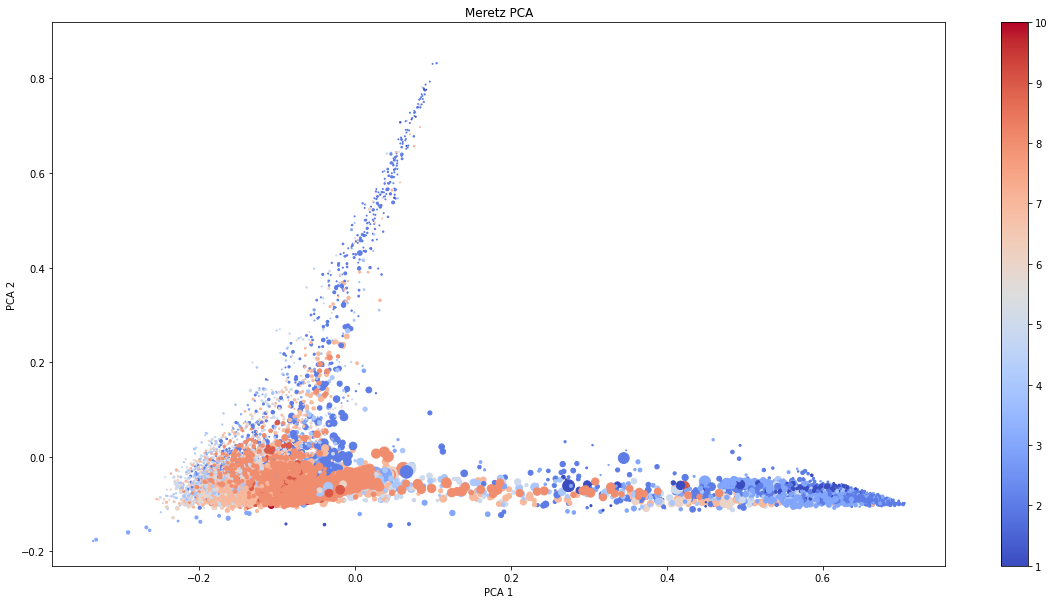

In [ ]:
plot_pca_for_only_kosher_df(df_2021_ballots,"מרצ")

הגודל של העיגולים מסמל את שכיחות ההצבעה למפלגה בקלפי, הצבעים הם על פי האשכול החברתי כלכלי, ניתן לראות ששכיחות ההצבעה למרצ נמצאת בקורלציה גבוהה עם האשכולות היותר גבוהים

In [ ]:
def difference_in_elcetion(merged_df,party):
    finish = merged_df.shape[0]
    dict_of_diff = {}
    for i in range(0,finish,2):
        differnce = merged_df[party].iloc[i]-merged_df[party].iloc[i+1]
        dict_of_diff[merged_df.iloc[i].name] = differnce    
    return pd.Series(dict_of_diff)
diff_series = difference_in_elcetion(merge_parties_perc,"מרצ")    

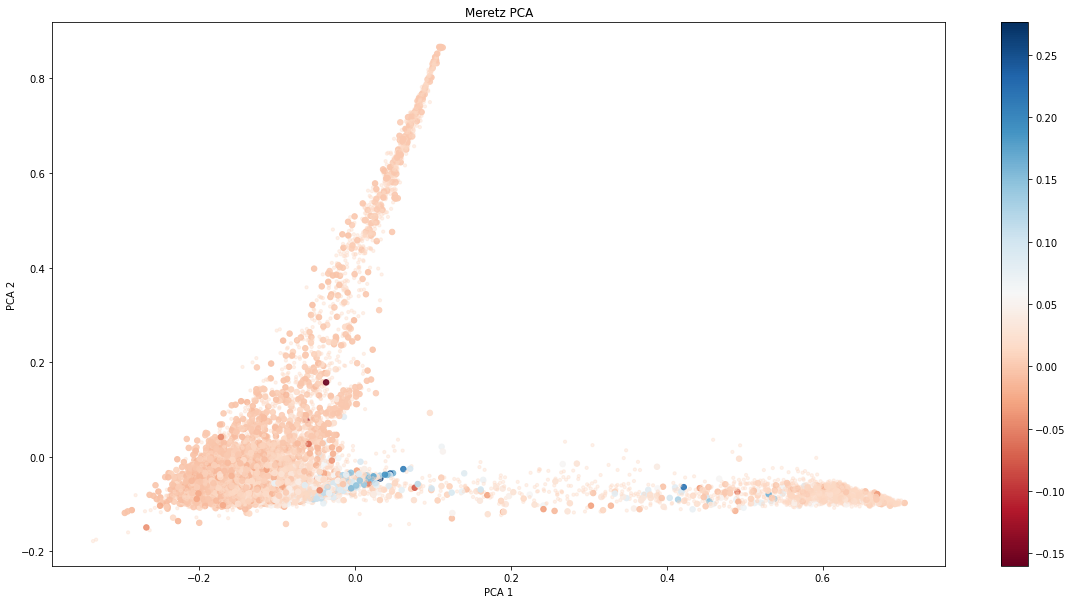

In [ ]:
def plot_pca_for_diff(df,party):
    location = df.columns.get_loc(party)
    norm = normalize(df,norm="l1",axis=1)
    diff_series = difference_in_elcetion(merge_parties_perc,"מרצ")
    diff_series.name = "diff"
    merge_for_size = pd.concat([df,diff_series],axis=1)
    for_alpha = ~merge_for_size["diff"].isna()
    alphas = np.where(for_alpha,0.9,0.35)
    size = np.where(for_alpha,30,10) 
    option1 = merge_for_size.fillna({"diff":diff_series.mean()})["diff"]
    two_dim_ballot = pca.fit_transform(norm)
    plt.figure(figsize=(20,10))
    plt.scatter(two_dim_ballot[:,0],two_dim_ballot[:,1],alpha=alphas,s=size,c = option1,cmap="RdBu")
    plt.colorbar()
    plt.title("Meretz PCA")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()
plot_pca_for_diff(df_2021_ballots, "מרצ")

הצבע מסמל את ההבדל באחוזי ההצבעה למרץ בין שתי מערכות הבחירות. כשההפרש חיובי (כחול) אחוז ההצבעה גדול יותר ב2021.

נשים לב שיש נקודות מודגשות ונקודות מטושטשות, הדגשנו רק את הקלפיות שהיו בשני מערכות הבחירות. ניתן להסיק מן הגרף שברוב הקלפיות אין הבדל משמעותי באחוזי ההצבעה בין שתי המערכות.

סעיף ו + ז

In [ ]:
def arrange_data_for_M(df,wanted_parties,with_no_vote=True):
  wanted_parties = list(wanted_parties)
  shared_kalpi = merge_parties_perc.index.unique()
  prap_for_M = df.loc[shared_kalpi]
  if with_no_vote: 
    prap_for_M["לא מצביעים"]=prap_for_M["בזב"]-prap_for_M["מצביעים"]
    wanted = prap_for_M[wanted_parties + ["לא מצביעים"]]
  else:
    wanted = prap_for_M[wanted_parties]
  return wanted

In [ ]:
shared_21 = arrange_data_for_M(df_2021_ballots_raw,parties_dict_2021.keys())
shared_20 = arrange_data_for_M(df_2020_ballots_raw,big_nine)
shared_21_no_votes = arrange_data_for_M(df_2021_ballots_raw,parties_dict_2021.keys(),False)
shared_20_no_votes = arrange_data_for_M(df_2020_ballots_raw,big_nine,False)

In [ ]:
def vote_move_to_party(share21,share20,party):  
  y = share21[party]
  model,score = nnls(share20, y)
  if model.size == 10:
    vote_for_party = pd.Series(model,index=big_nine+["לא מצביעים"])
  else:
      vote_for_party = pd.Series(model,index=big_nine)
  return vote_for_party

In [ ]:
def create_big_M(share21,share20):
  move_dict = {}
  for party in share21.columns:
    moves_to_party = vote_move_to_party(share21,share20,party)
    move_dict[party] = moves_to_party
    big_M = pd.DataFrame(move_dict) 
    stohastic_M = big_M.div(big_M.sum(axis=1),0)
  return stohastic_M    

In [ ]:
big_m = create_big_M(shared_21,shared_20)
vec1 = big_m.iloc[0].round(4)
split_names_21 = big_m.columns
vec2 = big_m["מרצ"]
split_names_20 = big_m.index

In [ ]:
def vec_heatmap(vec, dict, split_names):
  plt.figure(figsize=(9, 6))
  if vec1.size==14:
    split_names = split_names.drop("לא מצביעים")
  names = dict.keys()
  names = [dict[name] for name in list(split_names)]
  if vec1.size==14:
    names.append("לא מצביעים")
  rev_names = [party[::-1] for party in names]
  for_heat = vec.values.reshape((-1,1))
  hey = sns.heatmap(for_heat, square=True,cmap="YlOrRd",annot=True,linewidths = 0.1 ,yticklabels= rev_names,xticklabels="p")
  plt.tight_layout()

# פלט סעיף ו

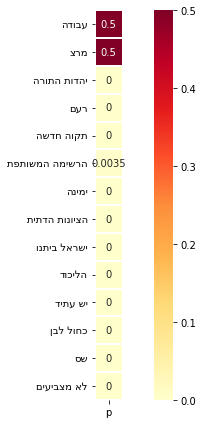

In [ ]:
vec_heatmap(vec1, parties_dict_2021, split_names_21)

בגרף זה הצגנו את הניבוי של מעברי הקולות של מפלגת העבודה-גשר-מרץ לבחירות 2021.

ניתן לראות חלוקה שווה בין העבודה ומרץ עם מספר קטן של קולות שהלכו לרשימה המשותפת.

את הניבוי עשינו בעזרת רגרסיית ריבועים פחותים אי שלילית.

# פלט סעיף ז

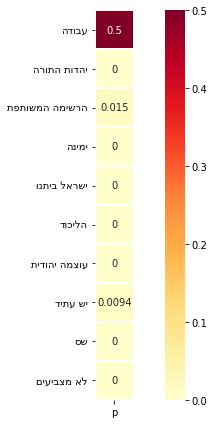

In [ ]:
vec_heatmap(vec2, parties_dict_2020, split_names_20)

בגרף זה הצגנו את הניבוי של מעברי הקולות של כלל המפלגות ב2020 אל מפלגת מרץ.

ניתן לראות שמחצית מהקולות למפלגת מרץ הגיעו ממפלגת העבודה, ומעט קולות הגיעו מהרשימה המשותפת ומיש עתיד

את הניבוי עשינו בעזרת רגרסיית ריבועים פחותים אי שלילית.

# סעיף ח (ענינו לפי מעבדה 9)

In [ ]:
def plot_resid(shareds21,shareds20,party):
  fig,axes = plt.subplots(1,2,figsize=(10,5))
  axes = axes.flat
  for i in range(2):
    bigM = create_big_M(shareds21[i],shareds20[i]) 
    estimate_21 = shareds20[i]@bigM
    resid_vec = estimate_21[party]-shareds21[i][party]
    norm_resid_vec = resid_vec.div(resid_vec.std())
    axes[i].scatter(estimate_21[party],norm_resid_vec,s=10,c="c",alpha=0.5,marker = "d")
    axes[i].axhline(y=norm_resid_vec.mean(), color='r', linestyle='--')
    if i == 0 :
      axes[i].set_title("with no votes in calculate")
    else:  
      axes[i].set_title("without no votes in calculate")  
  fig.tight_layout()
  plt.show

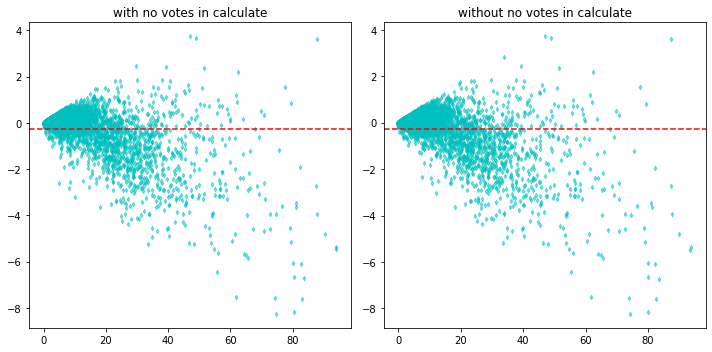

In [ ]:
both_shared_21 = [shared_21,shared_21_no_votes]
both_shared_20 = [shared_20,shared_20_no_votes] 
plot_resid(both_shared_21,both_shared_20,"מרצ")

בגרפים אלו חישבנו והצגנו את השאריות המתוקננות של המודל כפונקציה של הניבויים על מנת לבדוק את איכות המודל, ואת השפעת הלא מצביעים על המודל בהקשר של המפלגה.

 ניתן לראות כי אין הבדל כמעט בין שני הגרפים כלומר ש"הלא מצביעים" לא השפיע על איכות המודל ועל הניבויים שלו.ואיכות המודל באופן כללי סבירה.


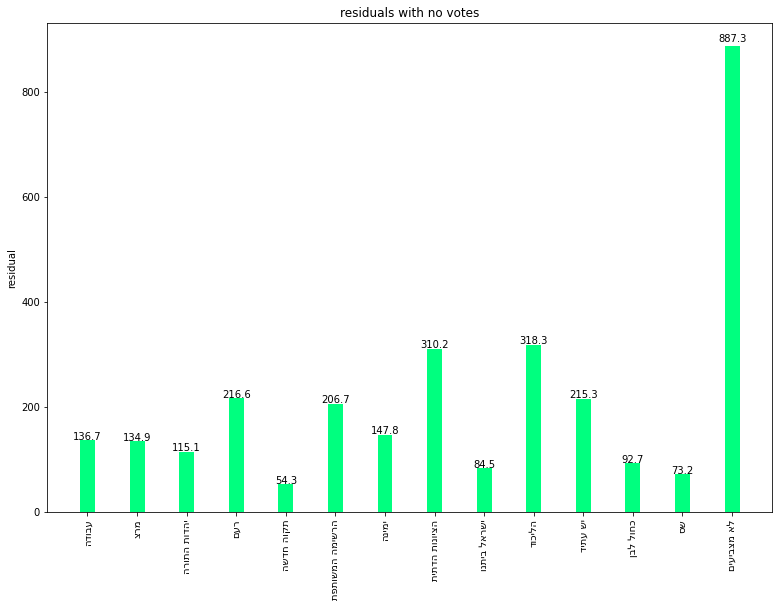

In [ ]:
def plot_residuals(shared21,shared20):
    names = [parties_dict_2021[name] for name in shared21.columns if name in parties_dict_2021.keys()]
    rev_names = [name[::-1] for name in names]
    n = shared21.shape[1] 
    bigs_m = create_big_M(shared21,shared20) 
    all_resid = (shared20@bigs_m - shared21).pow(2)
    party_resid = all_resid.mean(axis=0)
    plt.figure(figsize=(13, 9))
    graph = plt.bar(np.arange(n),party_resid,0.3,color="springgreen")
    if shared21.shape[1] == 14:
       rev_names.append(shared21.columns[-1][::-1])
    plt.xticks(range(n),rev_names,rotation=90)
    plt.ylabel("residual")
    if shared21.shape[1] == 14:
      plt.title("residuals with no votes")
    else:
        plt.title("only parties residuals")
    for i,bar in enumerate(graph):
      width = bar.get_width()
      height = bar.get_height()
      x, y = bar.get_xy()
      plt.text(x+width/2,
              y+height*1.01,
              str(party_resid.iloc[i].round(1)),
              ha='center')
    plt.show()
plot_residuals(shared_21,shared_20)

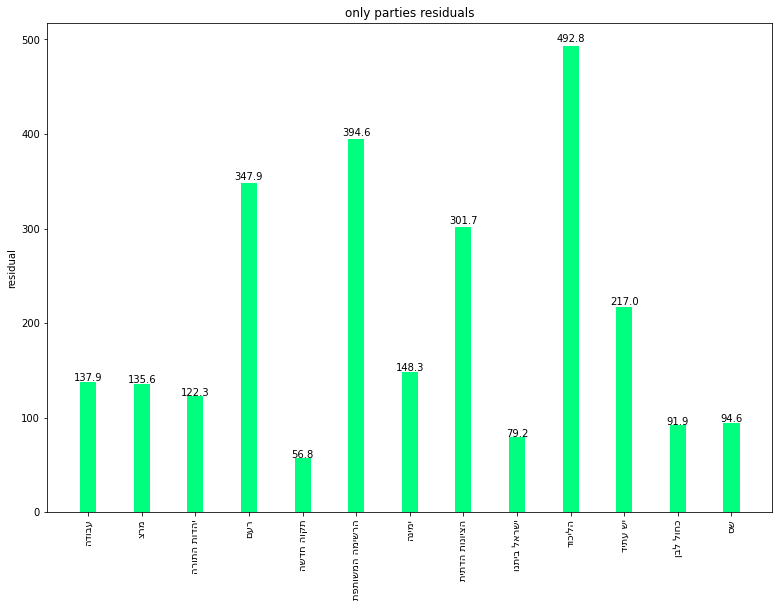

In [ ]:
plot_residuals(shared_21_no_votes,shared_20_no_votes)

התחזיות בשביל מרץ באופן יחסי לשאר המפלגות הם טובות, כאשר בגרפים אנו

בגרף ניתן לראות את ממוצע השאריות הריבעויות לכל מפלגה, ניתן לראות שהתחזית עבור מרץ היא טובה באופן יחסי לשאר המפלגות. ובנוסף ניתן לראות משני הגרפים שעמודת הלא מצביעים אינה משפיעה על הניבוי של מרץ.

# ט

In [ ]:
shared_votes_2021 = final_merge.iloc[np.arange(0,final_merge.shape[0],2)]
shared_votes_2020 = final_merge.iloc[np.arange(1,final_merge.shape[0],2)]
original_suspect = (shared_votes_2021["מרצ"] - shared_votes_2020["מרצ"]).pow(2).nlargest(10).index
left_parties = ["מרצ","כן","פה","אמת"]
left_dict = {key:val for key,val in parties_dict_2021.items() if key in left_parties}
left_diff = (shared_votes_2021[left_parties].sum(axis = 1) - shared_votes_2020[left_parties].sum(axis = 1)).pow(2).nlargest(10).index
meretz_perc_diff = (merge_parties_perc["מרצ"].iloc[np.arange(0,final_merge.shape[0],2)] - merge_parties_perc["מרצ"].iloc[np.arange(1,final_merge.shape[0],2)]).pow(2).nlargest(10).index

In [ ]:
def split_years(df):
  n = df.shape[0]
  location_of_21 = np.arange(0,n,2)
  location_of_20 = location_of_21 + 1
  df_21 = df.iloc[location_of_21]
  df_20 = df.iloc[location_of_20]
  return  df_21,df_20

In [ ]:
def plot_suspicous(suspicous_kalpi,merge_prec):
    width = 0.3
    for_title = " קלפי "
    prec_of_wanted = merge_prec.loc[suspicous_kalpi]
    prec_of_wanted = prec_of_wanted[parties_dict_2021.keys()]
    prec_of_wanted_21,prec_of_wanted_20 = split_years(prec_of_wanted) 
    fig , axes = plt.subplots(figsize = (16,8),nrows = 2,ncols = 5)
    axes = axes.flat
    rev_names = [parties_dict_2021[name][::-1] for name in parties_dict_2021.keys()]
    for i in range(10):
        ballot_21 = prec_of_wanted_21.iloc[i]
        ballot_20 = prec_of_wanted_20.iloc[i]  
        axes[i].bar(np.arange(13), list(ballot_21),0.3,color = "springgreen")
        axes[i].bar(np.arange(13)+width, list(ballot_20),0.3,color = "mediumseagreen")
        axes[i].set_xticks(range(0,13))
        axes[i].set_title(str(ballot_21.name[1])+for_title[::-1]+str(ballot_21.name[0])[::-1])
        axes[i].set_xticklabels(rev_names,rotation=90)
    fig.tight_layout()     
    plt.gca().legend(('2021','2020'))
    plt.show 

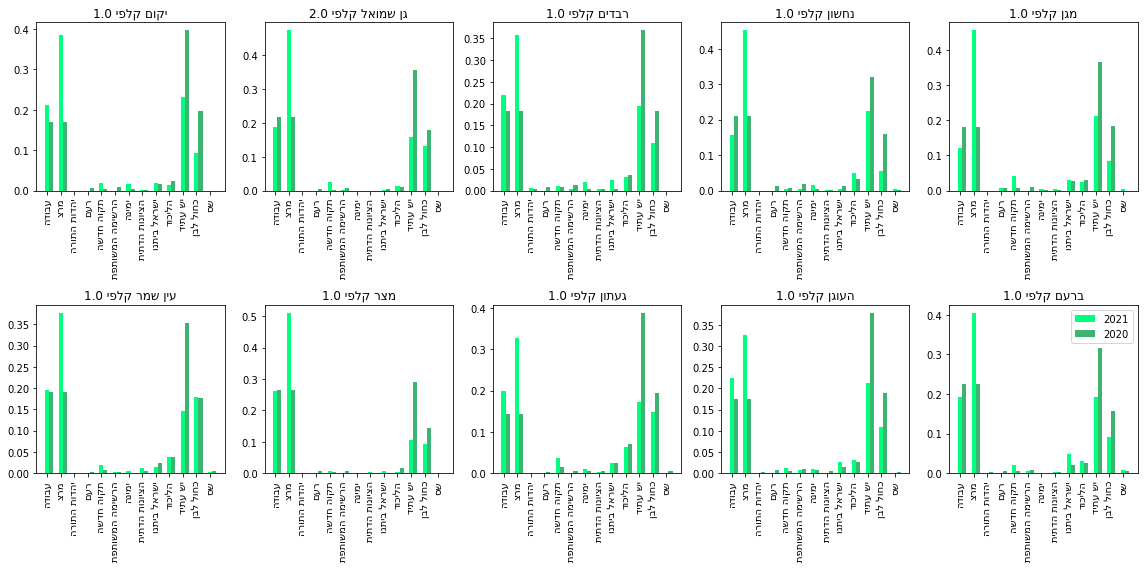

In [ ]:
plot_suspicous(original_suspect,merge_parties_perc)

חישבנו על פי מרץ את ההפרש הריבועי של המצביעים בין הבחירות. והנחנו כי הערכים הכי גדולים יהיו קלפיות חשודות מהסיבה שהייתה תזוזת קולות גדולה באופן חריג במפלגת מרץ. מעניין לראות שבכל קלפיות אלו מרץ מקבלת יותר אחוזי הצבעה בשנת 2021 מאשר בשנת 2020 ובנוסף לכך הפיצול מאמת היה חצי אמת וחצי מרץ לכן היינו מצפים שאחוזי ההצבעה יהיו שווים בין השניים בשנת 2021 גם, אך ניתן לראות שבכולם מרץ קיבלו הרבה יותר אחוזי הצבעה שזה מוביל אותנו להבנה שבקלפיות אלה רוב התומכים בשנת 2020 של אמת הגיעו מתומכי מרץ.

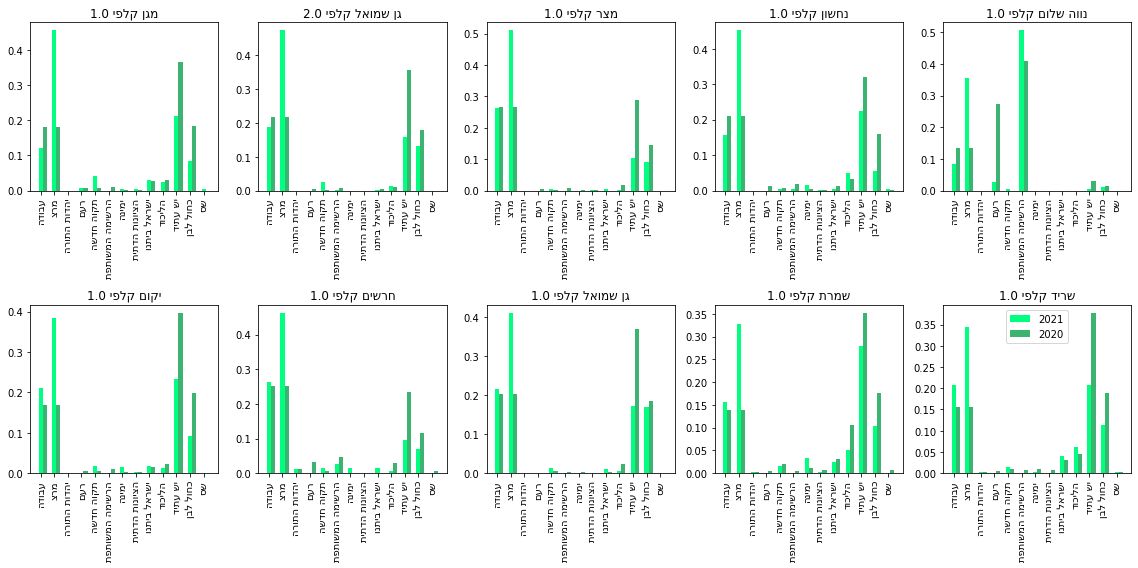

In [ ]:
plot_suspicous(meretz_perc_diff,merge_parties_perc)

בגרפים אלו ניתן לראות את עשרת הקלפיות שבהם השינוי באחוזי ההצבעה למרץ היה הכי גדול. ראשית ניתן לראות שכמה מהקלפיות זהות לאותם קלפיות שבהם הפרש הקולות היה גדול. גם כאן ניתן לראות שבכל הגרפים מרץ קיבלו יותר אחוזי הצבעה ב2021 מאשר 2020, ישנם ישובים שבהם גם מרץ וגם העבודה התחזקו וניתן להסיק מכאן שבאופן כללי שתי המפלגות התחזקו וישנם ישובים שבהם מרץ התחזקו ועבודה נחלשו ואנו נניח שבישובים אלה קולות נעו מהעבודה אל מרץ

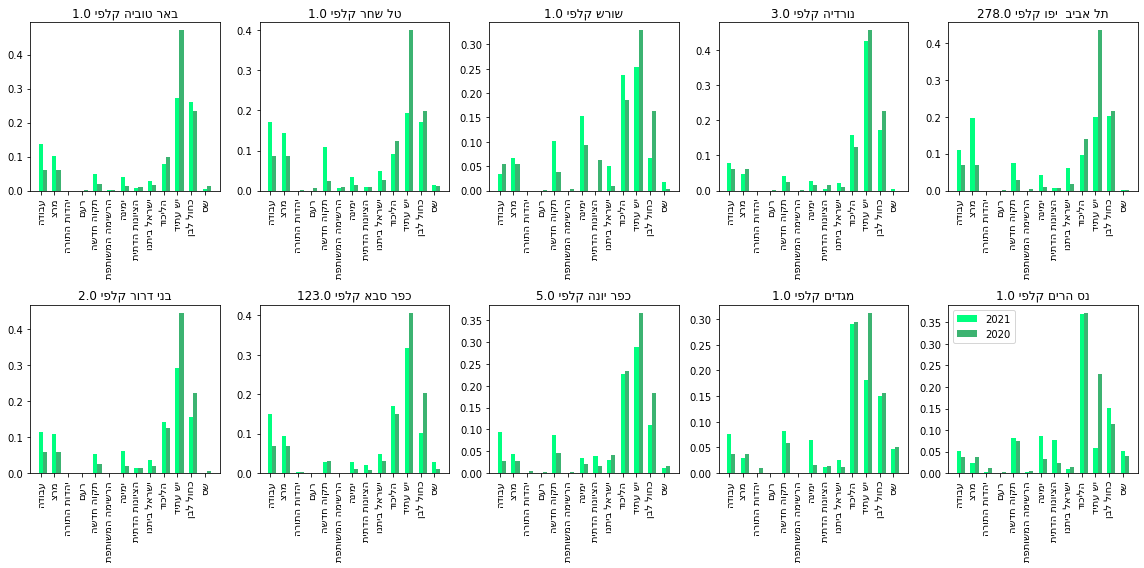

In [ ]:
plot_suspicous(left_diff,merge_parties_perc)

בגרפים אלו בחרנו את השינוי הגושי (מרכז שמאל), כלומר את השינוי הגדול ביותר שחל בכל מפלגות הגוש (מרץ, יש עתיד, כחול לבן והעבודה) ביחד בין שנת 2020 ולבין שנת 2021. שינוי זה יכול להצביע על חשד בקלפי שכן זה דבר חריג שישנם הרבה מצביעים שלא רק שהצביעו למפלגה שונה אלא גם הצביעו לגוש שונה.

ניתן לראות שבכל קלפיות אלו יש עתיד איבדו הרבה קולות לטובת מרץ ועבודה וכן מעט קולות לטובת ימינה ותקווה חדשה.

In [ ]:
!jupyter nbconvert --to html Copy_of_final_report.ipynb

[NbConvertApp] Converting notebook Copy_of_final_report.ipynb to html
[NbConvertApp] Writing 490638 bytes to Copy_of_final_report.html
